# `incdbscan` meets Iris

This is an introduction to the API of the `incdbscan` package. The logic of DBSCAN and its hyperparameters will not be covered here. Those can be checked at scikit-learn's [documentation about DBSCAN](https://scikit-learn.org/stable/modules/clustering.html#dbscan).

In [1]:
cd ..

/home/xyz


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

def plot_iris(array, labels=None):
    colors = ['blue', 'green', 'yellow', 'black', 'orange', 'purple', 'red', 'silver']  # quite hacky...
    plt.figure(figsize=(10, 10))
    
    if labels is not None:
        for label in set(labels):
            rows = label == labels
            plt.scatter(array[rows, 0], array[rows, 1], c=colors[int(label)], label=str(int(label)))
        plt.legend(title='Cluster labels')
    else:
        plt.scatter(array[:, 0], array[:, 1], c=labels, cmap='Set1')
    
    plt.xlim([4.0, 8.5])
    plt.ylim([1.75, 4.5])
    plt.xlabel('sepal length (cm)')
    plt.ylabel('sepal width (cm)')
    plt.show()


The data set we are going to cluster is 2-D variant of the Iris dataset (although `incdbscan` is capable of dealing with higher dimensions). The data set is split into two batches of points. We take a peek to see all data points first, then get to clustering.

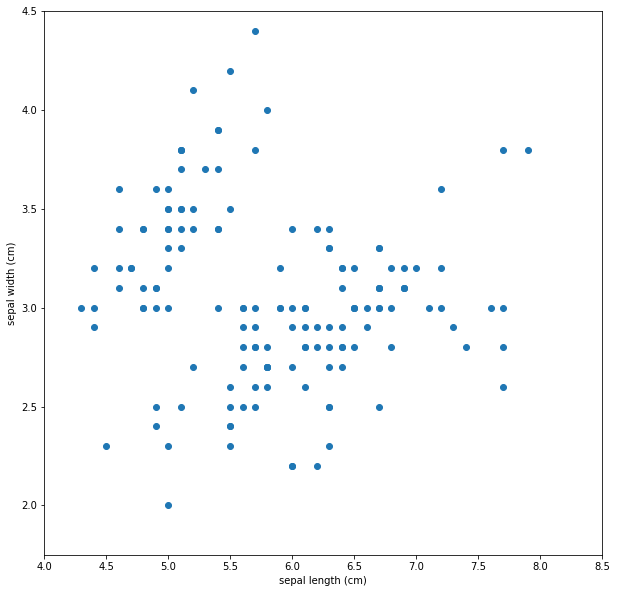

In [3]:
X = load_iris()['data'][:, :2]
X_1, X_2 = X[:75], X[75:]

plot_iris(X)

In [4]:
from incdbscan import IncrementalDBSCAN
clusterer = IncrementalDBSCAN(eps=0.25, min_pts=5)

## Input data shape

All 3 main methods - `insert`, `delete` and `get_cluster_labels` - expect data points to be in a 2-D `ndarray` of shape `(n_samples, n_features)`, but also can be in a pandas `DataFrame` or in a list of data points stored in 1-D `ndarray`s of shape `(n_features,)`.

## Insert data points with `insert`
First insert a batch of points into the clusterer. Note that `insert` returns with the `IncrementalDBSCAN` instance itself.

In [5]:
clusterer.insert(X_1)

The same points can be inserted again if wanted. Let's insert the first 10 data points again into the clusterer. Now these points will be there two times.

In [6]:
clusterer.insert(X_1[:10])

## Obtain cluster labels with `get_cluster_labels`
This method helps us gain the cluster labels. In contrast with scikit-learn's `DBSCAN`, the labels are obtained not for all objects but for obejcts we specifically ask cluster labels for. Let's get the cluster labels for the whole 1st batch and see them on a plot!

In [7]:
labels_1 = clusterer.get_cluster_labels(X_1)

In [8]:
labels_1

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

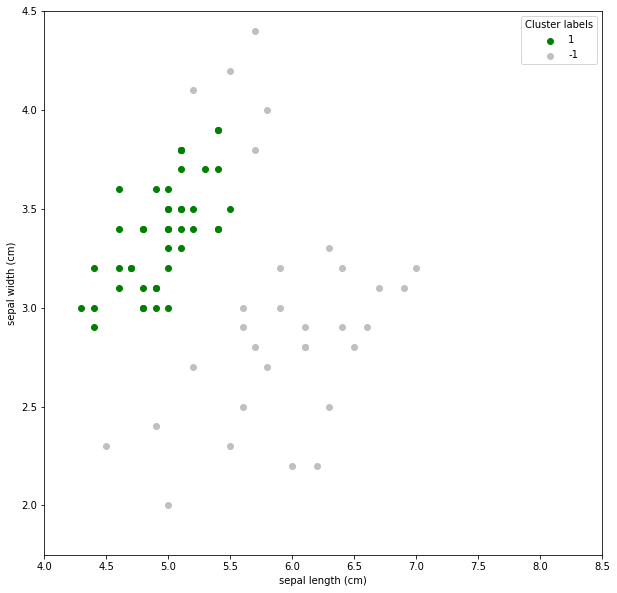

In [9]:
plot_iris(X_1, labels_1)

There is one cluster according to IncrementalDBSCAN -- the points shown in green. But so far many of the points are found to be noise -- these are the grey points. The amount of noise is quite big because of the relatively low value of `eps`.

If we pass such data points to `get_cluster_labels` that are missing from the clustering (i.e., were not inserted so far, or were inserted but also deleted), two things will happen. A warning will show up, and the labels for these missing objects will have a value of `numpy.nan`.

In [10]:
labels_with_missing = clusterer.get_cluster_labels(X[70:80])

/home/xyz/incdbscan/incrementaldbscan/incrementaldbscan.py:144: IncrementalDBSCANWarning: No label was retrieved for object at position 5 because there is no such object in the object set.
  f'No label was retrieved for object at position {ix} '
/home/xyz/incdbscan/incrementaldbscan/incrementaldbscan.py:144: IncrementalDBSCANWarning: No label was retrieved for object at position 6 because there is no such object in the object set.
  f'No label was retrieved for object at position {ix} '
/home/xyz/incdbscan/incrementaldbscan/incrementaldbscan.py:144: IncrementalDBSCANWarning: No label was retrieved for object at position 7 because there is no such object in the object set.
  f'No label was retrieved for object at position {ix} '
/home/xyz/incdbscan/incrementaldbscan/incrementaldbscan.py:144: IncrementalDBSCANWarning: No label was retrieved for object at position 8 because there is no such object in the object set.
  f'No label was retrieved for object at position {ix} '
/home/xyz/incdbs

In [11]:
labels_with_missing

array([-1., -1., -1., -1., -1., nan, nan, nan, nan, nan])

Let's insert the 2nd batch of data points and see the clustering of all data points.

In [12]:
labels_all = clusterer.insert(X_2).get_cluster_labels(X)

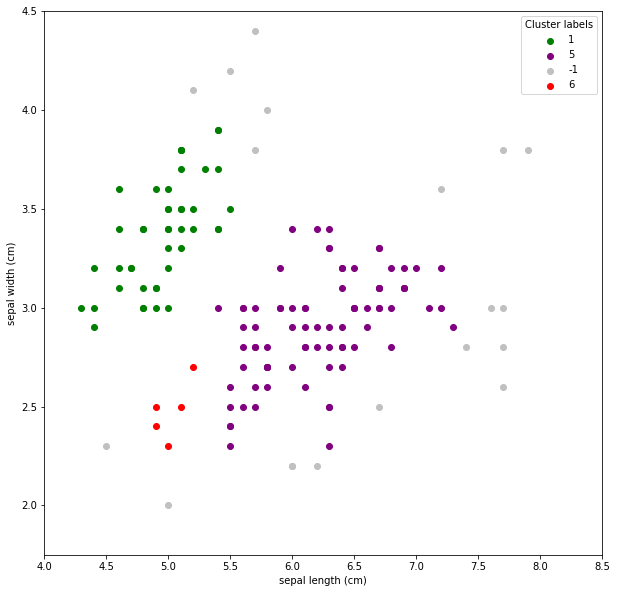

In [13]:
plot_iris(X, labels_all)

Thanks to the new points, two clusters emerged from the set of points that were previously noise: the purple and the red cluster. 

## Delete data points with `delete`

One just have to pass the batch of data points to delete. Let's try it out by deleting the first batch of data points, and get the labels of the second batch in one line.

In [14]:
labels_2 = clusterer.delete(X_1).get_cluster_labels(X_2)

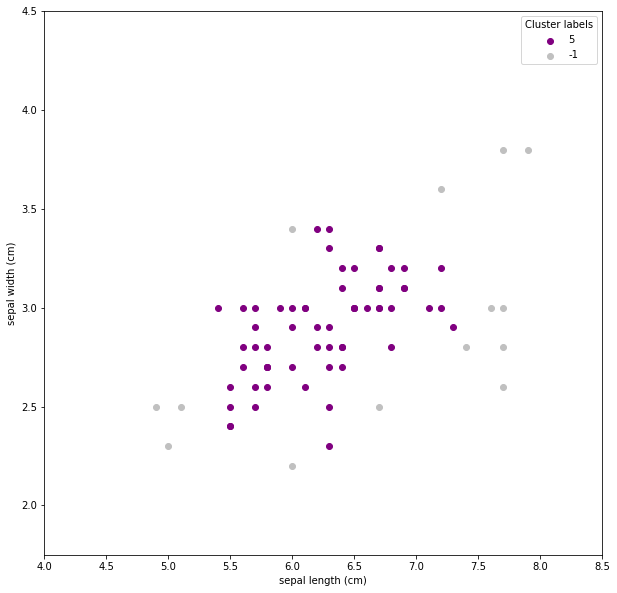

In [15]:
plot_iris(X_2, labels_2)

Only the purple cluster remained.

But remember that we inserted the first 10 data points from the first batch two times? When we invoked `delete(X_1)`, only one of the duplicated points remained. So we still can get the labels of the first 10 points. Just by peeking into the values we can see that they became noise.

In [16]:
labels_10 = clusterer.get_cluster_labels(X_1[:10])

In [17]:
labels_10

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

One thing left to note. If we try to delete such points that are missing from the clustering, we will not succeed but have to face a warning. Here first we check what happens if we try to delete the first 10 points (which currently are still in the clustering), and then what happens if we try to delete them again.

In [18]:
clusterer.delete(X_1[:10])

In [19]:
clusterer.delete(X_1[:10])

/home/xyz/incdbscan/incrementaldbscan/incrementaldbscan.py:107: IncrementalDBSCANWarning: Object at position 0 was not deleted because there is no such object in the object set.
  f'Object at position {ix} was not deleted because '
/home/xyz/incdbscan/incrementaldbscan/incrementaldbscan.py:107: IncrementalDBSCANWarning: Object at position 1 was not deleted because there is no such object in the object set.
  f'Object at position {ix} was not deleted because '
/home/xyz/incdbscan/incrementaldbscan/incrementaldbscan.py:107: IncrementalDBSCANWarning: Object at position 2 was not deleted because there is no such object in the object set.
  f'Object at position {ix} was not deleted because '
/home/xyz/incdbscan/incrementaldbscan/incrementaldbscan.py:107: IncrementalDBSCANWarning: Object at position 3 was not deleted because there is no such object in the object set.
  f'Object at position {ix} was not deleted because '
/home/xyz/incdbscan/incrementaldbscan/incrementaldbscan.py:107: Incremen